In [1]:
import pandas as pd
import numpy as np
import math 
from datetime import datetime

import matplotlib.pyplot as plt  
import seaborn as sns

In [2]:
# Import the data data
subscriptions = pd.read_csv('subscriptionsdataFINAL.csv') 
visitation_part1 = pd.read_csv('visitationdataPART1.csv') 
visitation_part2 = pd.read_csv('visitationdataPART2.csv')  

In [3]:
# Chane the timestamp
subscriptions['Join Date'] =  pd.to_datetime(subscriptions['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
subscriptions['Join_year'] = pd.DatetimeIndex(subscriptions['Join Date']).year
subscriptions['End Date'] =  pd.to_datetime(subscriptions['End Date'].str.upper(), format='%b-%y', yearfirst=False)
subscriptions.dropna()
subscriptions.head()

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Join_year
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992,2011
1,Greenwich,2018-06-01,A,Female,Standard,NaT,2,1972,2018
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985,2018
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972,2015
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982,2015


In [4]:
## Add the duration data to the subscriptions data
date_min = min (subscriptions['Join Date'].min(),subscriptions['End Date'].min() )
date_max = max (subscriptions['Join Date'].max(),subscriptions['End Date'].max() )
dates = pd.date_range(date_min, date_max, freq = 'MS')
customers_total = pd.DataFrame({'Date':dates})
customers_total.head(), customers_total.shape
subscriptions['Duration'] = np.where(subscriptions['End Date'].isna(), 
                                     (date_max - subscriptions['Join Date']), 
                                     (subscriptions['End Date'] - subscriptions['Join Date']) )
subscriptions['Duration'] = np.where(subscriptions['End Date'].isna(), 
                                     (date_max - subscriptions['Join Date']), 
                                     (subscriptions['End Date'] - subscriptions['Join Date']) )
##convert the difference in months
subscriptions['Duration'] = (subscriptions['Duration'] /  np.timedelta64(1, 'M') ).apply(math.floor)
subscriptions

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Join_year,Duration
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992,2011,0
1,Greenwich,2018-06-01,A,Female,Standard,NaT,2,1972,2018,6
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985,2018,7
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972,2015,2
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982,2015,7
...,...,...,...,...,...,...,...,...,...,...
850028,Lewisham,2018-12-01,A,Male,Standard,NaT,850029,1995,2018,0
850029,Tower Hamlets,2013-10-01,B,Male,Standard,2014-02-01,850030,1987,2013,4
850030,Redbridge,2018-05-01,C1,Female,Standard,2018-09-01,850031,1985,2018,4
850031,Camden,2017-07-01,B,Female,Standard,2017-09-01,850032,1978,2017,2


In [16]:
# Monthly
# Calculate the number of member joined, the number of member left, net member, cumulative member
member_joined_data = subscriptions.groupby(['Join Date','Subscription Type']).size().reset_index(name='Number_of_Member_Joined')
member_joined_data = member_joined_data.rename(columns={'Join Date': "Date"})
member_left_data = subscriptions.groupby(['End Date','Subscription Type']).size().reset_index(name='Number_of_Member_Left')
member_left_data=member_left_data.rename(columns={'End Date': "Date"})
member_left_data['Date']=member_left_data['Date'] + pd.DateOffset(months=1)
member_data = pd.merge(member_joined_data,member_left_data,on = ['Subscription Type','Date'],how='outer').sort_index().replace({np.nan:0})
member_data['Net_Member'] = member_data['Number_of_Member_Joined'] - member_data['Number_of_Member_Left'] 
member_data = pd.DataFrame(member_data.groupby(['Date','Subscription Type']).sum())
member_data['Cumulative_Member'] = member_data.groupby(level=-1)['Net_Member'].cumsum()
member_data

Number_of_Member_Joined  Number_of_Member_Left  \
Date       Subscription Type                                                   
2009-05-01 Flexible                             167.0                    0.0   
           Standard                             532.0                    0.0   
2009-06-01 Flexible                             124.0                   47.0   
           Standard                             428.0                    1.0   
2009-07-01 Flexible                             266.0                   52.0   
...                                               ...                    ...   
2018-11-01 Standard                           10248.0                 9685.0   
2018-12-01 Flexible                            2596.0                 2711.0   
           Standard                            9398.0                 9625.0   
2019-01-01 Flexible                               0.0                 2684.0   
           Standard                               0.0                 9840.0   

                              Net_Member  Cumulative_Member  
Date       Subscription Type                                 
2009-05-01 Flexible                167.0              167.0  
           Standard                532.0              532.0  
2009-06-01 Flexible                 77.0              244.0  
           Standard                427.0              959.0  
2009-07-01 Flexible                214.0              458.0  
...                                  ...                ...  
2018-11-01 Standard                563.0            56522.0  
2018-12-01 Flexible               -115.0             8606.0  
           Standard               -227.0            56295.0  
2019-01-01 Flexible              -2684.0             5922.0  
           Standard              -9840.0            46455.0  

[234 rows x 4 columns]

In [17]:
# Monthly
# Calculate the revenue
date_while_price_changed = pd.Timestamp('2016-01-01') 
date_min = pd.Timestamp('2009-05-01') 
date_max = pd.Timestamp('2019-01-01') 
dates_before_price_change = pd.date_range(date_min, date_while_price_changed, freq = 'MS')
dates_after_price_change = pd.date_range(date_while_price_changed, date_max, freq = 'MS')
Flexible_data = pd.DataFrame(member_data.xs('Flexible', level=1, drop_level=False))
Standard_data = pd.DataFrame(member_data.xs('Standard', level=1, drop_level=False))
Flexible_data.loc[dates_before_price_change,'Membership_Revenue'] = Flexible_data.loc[dates_before_price_change,'Cumulative_Member'] * 25.99
Flexible_data.loc[dates_after_price_change,'Membership_Revenue'] = Flexible_data.loc[dates_after_price_change,'Cumulative_Member'] * 30.99
Standard_data.loc[dates_before_price_change,'Membership_Revenue'] = Standard_data.loc[dates_before_price_change,'Cumulative_Member'] * 20.99
Standard_data.loc[dates_after_price_change,'Membership_Revenue'] = Standard_data.loc[dates_after_price_change,'Cumulative_Member'] * 26.99
Flexible_data = Flexible_data['Membership_Revenue']
Standard_data = Standard_data['Membership_Revenue']
Revenue_data = pd.DataFrame(pd.concat([Flexible_data, Standard_data]))
member_data = pd.merge(member_data,Revenue_data,on = ['Date','Subscription Type'],how='left')
member_data['Join_Revenue'] = member_data['Number_of_Member_Joined'] * 5
member_data['Total_Revenue'] = member_data['Membership_Revenue'] +  member_data['Join_Revenue']
member_data

Number_of_Member_Joined  Number_of_Member_Left  \
Date       Subscription Type                                                   
2009-05-01 Flexible                             167.0                    0.0   
           Standard                             532.0                    0.0   
2009-06-01 Flexible                             124.0                   47.0   
           Standard                             428.0                    1.0   
2009-07-01 Flexible                             266.0                   52.0   
...                                               ...                    ...   
2018-11-01 Standard                           10248.0                 9685.0   
2018-12-01 Flexible                            2596.0                 2711.0   
           Standard                            9398.0                 9625.0   
2019-01-01 Flexible                               0.0                 2684.0   
           Standard                               0.0                 9840.0   

                              Net_Member  Cumulative_Member  \
Date       Subscription Type                                  
2009-05-01 Flexible                167.0              167.0   
           Standard                532.0              532.0   
2009-06-01 Flexible                 77.0              244.0   
           Standard                427.0              959.0   
2009-07-01 Flexible                214.0              458.0   
...                                  ...                ...   
2018-11-01 Standard                563.0            56522.0   
2018-12-01 Flexible               -115.0             8606.0   
           Standard               -227.0            56295.0   
2019-01-01 Flexible              -2684.0             5922.0   
           Standard              -9840.0            46455.0   

                              Membership_Revenue  Join_Revenue  Total_Revenue  
Date       Subscription Type                                                   
2009-05-01 Flexible                      4340.33         835.0        5175.33  
           Standard                     11166.68        2660.0       13826.68  
2009-06-01 Flexible                      6341.56         620.0        6961.56  
           Standard                     20129.41        2140.0       22269.41  
2009-07-01 Flexible                     11903.42        1330.0       13233.42  
...                                          ...           ...            ...  
2018-11-01 Standard                   1525528.78       51240.0     1576768.78  
2018-12-01 Flexible                    266699.94       12980.0      279679.94  
           Standard                   1519402.05       46990.0     1566392.05  
2019-01-01 Flexible                    183522.78           0.0      183522.78  
           Standard                   1253820.45           0.0     1253820.45  

[234 rows x 7 columns]

In [18]:
# Yearly
# The number of members and the total revenue
member_data_yearly=member_data.reset_index()
member_data_yearly['Year'] = member_data_yearly.apply(lambda row: row['Date'].year,axis=1)
member_data_yearly=member_data_yearly.groupby(['Year','Subscription Type']).sum()
member_data_yearly.head()

Number_of_Member_Joined  Number_of_Member_Left  \
Year Subscription Type                                                   
2009 Flexible                            1989.0                 1046.0   
     Standard                            7050.0                 1910.0   
2010 Flexible                            5048.0                 4418.0   
     Standard                           18069.0                13976.0   
2011 Flexible                           10304.0                 8684.0   

                        Net_Member  Cumulative_Member  Membership_Revenue  \
Year Subscription Type                                                      
2009 Flexible                943.0             4642.0           120645.58   
     Standard               5140.0            22511.0           472505.89   
2010 Flexible                630.0            15118.0           392916.82   
     Standard               4093.0            88947.0          1866997.53   
2011 Flexible               1620.0            29857.0           775983.43   

                        Join_Revenue  Total_Revenue  
Year Subscription Type                               
2009 Flexible                 9945.0      130590.58  
     Standard                35250.0      507755.89  
2010 Flexible                25240.0      418156.82  
     Standard                90345.0     1957342.53  
2011 Flexible                51520.0      827503.43

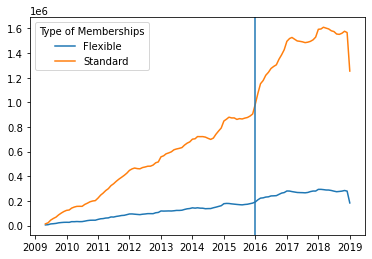

In [21]:
#Plot the chart of monthly revenue
date_min = pd.Timestamp('2009-05-01') 
date_max = pd.Timestamp('2019-01-01') 
Date = pd.date_range(date_min, date_max, freq = 'MS')
Flexible_data = pd.DataFrame(member_data.xs('Flexible', level=1, drop_level=False))
Standard_data = pd.DataFrame(member_data.xs('Standard', level=1, drop_level=False))
Flexible = Flexible_data['Total_Revenue']
Standard = Standard_data['Total_Revenue']
plt.plot(Date,Flexible,label='Flexible')
plt.plot(Date,Standard,label='Standard')
plt.legend(title='Type of Memberships')
plt.axvline(x='2016-01-01')

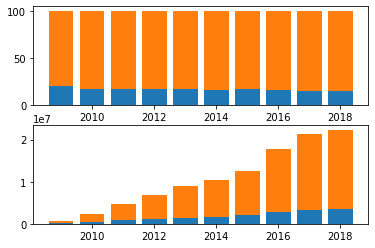

In [38]:
# Plot the Percent stacked barplot and barplot of yearly revenue,seperating the subscription type
r =  np.arange(2009,2019)
Flexible_data = pd.DataFrame(member_data_yearly.xs('Flexible', level=1, drop_level=False)).drop([2019])
Standard_data = pd.DataFrame(member_data_yearly.xs('Standard', level=1, drop_level=False)).drop([2019])
Flexible_Revenue = Flexible_data['Total_Revenue']
Standard_Revenue = Standard_data['Total_Revenue']
totals = [i+j for i,j in zip(Flexible_Revenue, Standard_Revenue)]
Flexible_revenue_stacked = [i / j * 100 for i,j in zip(Flexible_Revenue, totals)]
Standard_revenue_stacked = [i / j * 100 for i,j in zip(Standard_Revenue, totals)] 
plt.subplot(2, 1, 1)
plt.bar(r,Flexible_revenue_stacked)
plt.bar(r,Standard_revenue_stacked, bottom=Flexible_revenue_stacked)
plt.subplot(2, 1, 2)
plt.bar(r,Flexible_Revenue)
plt.bar(r,Standard_Revenue, bottom=Flexible_Revenue)
plt.show()

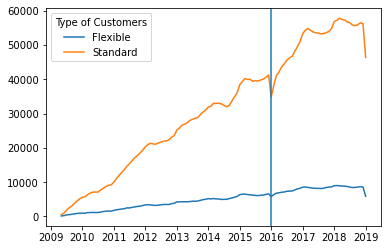

In [35]:
# Plot the cumulative members monthly
Dates = pd.date_range(min(Date), max(Date), freq = 'MS')
Flexible = member_data.xs('Flexible', level=1, drop_level=False)['Cumulative_Member']
Standard = member_data.xs('Standard', level=1, drop_level=False)['Cumulative_Member']
plt.plot(Dates,Flexible,label='Flexible')
plt.plot(Dates,Standard,label='Standard')
plt.legend(title='Type of Customers')
plt.axvline(x='2016-01-01')

In [ ]:
# Draw the growth of new standard member and new flexible member
Date = Cumulative_Members_seperating_revenue['Date']
Flexible = Cumulative_Members_seperating_revenue['New_flexible_member']
Standard = Cumulative_Members_seperating_revenue['New_standard_member']
plt.plot(Date,Flexible,label='Flexible')
plt.plot(Date,Standard,label='Standard')
plt.legend(title='Type of Memberships')
plt.axvline(x='2016-01-01')